### Model definition & Parameter Estimation

**1. Purpose of defining the mechanistic model**
- finding the optimal parameters
- finding the optimal equations for mu and qs

**2. Procedure of model definition**
- Generating parameter sets by applying **Latin Hypercube Sampling**
- Calculating the **RMSE** of model and experiment and create plot
- Comparison based on RMSE and visual analysis

**Theory of Latin Hypercube Sampling** (https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube)

- quasi-random sampling method
- dividing the subspace of each vector component into disjoint subsets meaning that two components have no element in common.
- insert equation
- since randomly paired, a LHS is not unique
- includes criterion to maximize the minimum distance between sample points

![LHS Grid](images/LHS_grid.png)

### Code

- First step: Testing each equation for qs with every parameter set that is generated with LHS sampling
- Second step: Loading & Comparison of parameter sets
- Third step: Testing parameters for chosen equation for qs (No.2)
- Fourth step: Manual understanding by changing the parameters one by one

In [1]:
import pandas as pd
import numpy as np
from C_model import get_LHS_samples
from C_model import objective_function_no1, plot_save_no1
from C_model import objective_function_no1_est, plot_save_no1_est, model_no1_est, plot_show_no1_est
from C_model import objective_function_no2, model_no2_est, plot_save_no2_est, plot_show_no2
from C_model import objective_function_no2_part1, objective_function_no2_part2

##### Batch No. 1 - Testing different ODE's for $q_s$ & Parameter Estimation

In [2]:
# Define possible equations for qs
qs0 = lambda qs_max, c_glucose, Ks: qs_max * c_glucose / (Ks + c_glucose) # -- MONOD
qs1 = lambda qs_max, c_glucose, Ks, Ki, glu_met: qs_max * c_glucose / (Ks + c_glucose) * (Ki / (Ki + glu_met)) # -- MONOD + NON COMPETITIVE INHIBITION
qs2 = lambda qs_max, c_glucose, Ks, c_biomass, lag: qs_max * c_glucose / (Ks + c_glucose) * (1 / (np.exp(c_biomass * lag))) # -- MONOD + METABOLIZED GLU

# Saving all equations in each list
qs_all=[qs0, qs1, qs2]

In [3]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [0.3, 0.5],    # Range for parameter 0 Yxs
    [0.5, 1.5],    # Range for parameter 1 qs_max
    [0.0, 1.0],   # Range for parameter 2 - Ks
    [1.0, 11.0],   # Range for parameter 3 - Ki
    [0.0, 0.01],    # Range for parameter 4 - m_s
    [0.001, 1.0],  # Range for parameter 5 - lag
]

In [5]:
LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)
LHS_samples.shape

(100, 6)

In [6]:
df_all_sets = pd.DataFrame(columns=['set', 'qs', 'Yxs', 'qs_max', 'Ks', 'Ki', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])
    for j in range(len(qs_all)):
        qs_eq = qs_all[j]; num_qs = j   

        # Make the predictions and calculate the error
        rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_function_no1(init_p, qs_eq, num_qs)
        # save the parameters in a dataframe
        append_list=[set_num, j, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
        rmse_one_set.append(append_list)

        # Make a plot and save it
        title = f'set{set_num}/ qs{j} - rmse: {round(rmse, 3)}'
        plot_name = f'set{set_num}_qs{j}_rmse{int(rmse)}'

        if rmse <= float(6):
            plot_save_no1(time_pred, biomass_pred, substrate_pred, volume_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'qs', 'Yxs', 'qs_max', 'Ks', 'Ki', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)


df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/estimation/0207_6/data.csv')

df_all_sets.head(10)

,set,qs,Yxs,qs_max,Ks,Ki,m_s,lag,rmse
284,94,2,0.493694,0.959567,0.076915,9.987638,0.005879,0.233722,4.663
29,9,2,0.491772,1.083275,0.969550,9.497721,0.001579,0.204987,4.671
263,87,2,0.378034,1.374070,0.792899,7.009797,0.000028,0.263490,4.678
8,2,2,0.377371,1.123265,0.789786,2.052882,0.008987,0.225642,4.741
182,60,2,0.365399,1.365260,0.829923,6.779025,0.006623,0.308486,4.887
227,75,2,0.357299,1.236725,0.234429,3.863658,0.001153,0.316360,5.027
233,77,2,0.437372,0.733023,0.993518,1.204770,0.008840,0.213390,5.133
242,80,2,0.474098,1.030183,0.146489,9.611732,0.003297,0.175370,5.140
254,84,2,0.482165,0.548027,0.112082,3.730518,0.008158,0.167621,5.156
14,4,2,0.416812,1.391724,0.916171,6.610556,0.006516,0.342987,5.192


##### Batch No. 1 - Parameter Estimation for $q_s = q_{s,max} \frac{S}{K_s + S} \frac{1}{e^{X*lag}}$

In [2]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [0.459, 0.460],     # Range for parameter 0 - Yxs
    [0.0001, 0.0023], # Range for parameter 1 - Yco2s
    [1.125, 1.126],     # Range for parameter 2 - qs_max
    [0.6810, 0.6815],     # Range for parameter 3 - Ks
    [0.0092, 0.0096],    # Range for parameter 4 - m_s
    [0.1910, 0.1916],   # Range for parameter 5 - lag
]

In [3]:
LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)
LHS_samples.shape

(100, 6)

In [4]:
df_all_sets = pd.DataFrame(columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    rmse_one_set = []
    init_p = list(LHS_samples[set_num, :])

    # Make the predictions and calculate the error
    rmse, time_pred, biomass_pred, substrate_pred, co2_pred = objective_function_no1_est(init_p)
    # save the parameters in a dataframe
    append_list=[set_num, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
    rmse_one_set.append(append_list)

    # Make a plot and save it
    title = f'set{set_num}/ rmse: {round(rmse, 3)}'
    plot_name = f'set{set_num}_rmse{int(rmse)}'

    if rmse <= float(6):
        plot_save_no1_est(time_pred, biomass_pred, substrate_pred, co2_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)

df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/batch_no2/estimation/data2.csv')

df_all_sets.head(10)

,set,Yxs,Yc02s,qs_max,Ks,m_s,lag,rmse
36,36,0.459087,0.001177,1.125415,0.681233,0.009227,0.191553,4.324
79,79,0.459123,0.000317,1.125171,0.681177,0.009269,0.191512,4.325
17,17,0.459336,0.000564,1.125894,0.681160,0.009204,0.191573,4.325
89,89,0.459776,0.000110,1.125548,0.681283,0.009319,0.191597,4.325
1,1,0.459909,0.000624,1.125443,0.681435,0.009306,0.191563,4.326
73,73,0.459119,0.001296,1.125587,0.681257,0.009233,0.191474,4.326
48,48,0.459769,0.000836,1.125667,0.681195,0.009217,0.191506,4.326
30,30,0.459280,0.001347,1.125519,0.681141,0.009328,0.191519,4.326
19,19,0.459164,0.001202,1.125820,0.681020,0.009221,0.191480,4.326
90,90,0.459260,0.002158,1.125230,0.681236,0.009259,0.191455,4.326


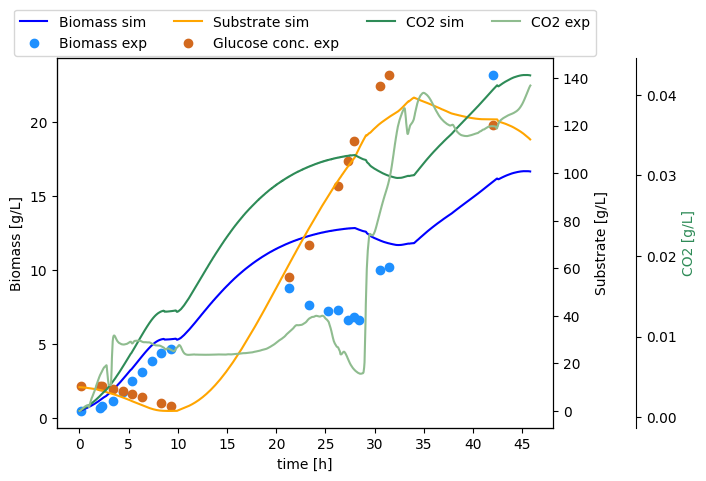

In [4]:
# in the 3rd step only the parameters were tested that are needed for the model
## set 30 was chosen as a starting point because of the following criteria
#- it covers the 3 fast growth phases
#- it covers the slow down phases when glucose was limited and when another limitation occured

p36 = [0.4597, 0.001177, 1.1255, 0.6814, 0.0094, 0.1913]
time_pred, biomass_pred, substrate_pred, co2_pred = model_no1_est(p36)
plot_show_no1_est(time_pred, biomass_pred, substrate_pred, co2_pred)

##### Batch No. 2 - Parameter Estimation for $q_s = q_{s,max} \frac{S}{K_s + S}$

In [4]:
# starting with range of 75% to 125% of the found value from last estimation
Yxs_lb = 0.46*0.9; Yxs_ub = 0.46*1.1
Yco2s_lb = 0.003*0.9; Yco2_ub = 0.003*1.1
qs_max_lb = 1.6*0.9; qs_max_ub = 1.6*1.1 # old value: 1.125
Ks_lb = 0.68*0.9; Ks_ub = 0.68*1.1
m_s_lb = 0.04*0.0; m_s_ub = 0.0*1.2

In [3]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [Yxs_lb, Yxs_ub],     # Range for parameter 0 - Yxs
    [Yco2s_lb, Yco2_ub], # Range for parameter 1 - Yco2s
    [qs_max_lb, qs_max_ub],     # Range for parameter 2 - qs_max
    [Ks_lb, Ks_ub],     # Range for parameter 3 - Ks
    [m_s_lb, m_s_ub],    # Range for parameter 4 - m_s
    [lag_lb, lag_ub],   # Range for parameter 5 - lag
]

LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)

print(LHS_samples.shape)
parameter_bounds

(100, 6)


[[0.41400000000000003, 0.5060000000000001],
 [0.0027, 0.0033000000000000004],
 [1.4400000000000002, 1.7600000000000002],
 [0.6120000000000001, 0.7480000000000001],
 [0.032, 0.048],
 [0.17217, 0.21043]]

In [4]:
df_all_sets = pd.DataFrame(columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])

    # Make the predictions and calculate the error
    rmse, time_pred, biomass_pred, substrate_pred, co2_pred = objective_function_no2(init_p)
    # save the parameters in a dataframe
    append_list=[set_num, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
    rmse_one_set.append(append_list)

    # Make a plot and save it
    title = f'set{set_num}/ rmse: {round(rmse, 3)}'
    plot_name = f'set{set_num}_rmse{int(rmse)}'

    if rmse <= float(3):
        plot_save_no2_est(time_pred, biomass_pred, substrate_pred, co2_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)

df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/batch_no2/estimation/data8.csv')

df_all_sets.head(10)

,set,Yxs,Yc02s,qs_max,Ks,m_s,lag,rmse
51,51,0.498487,0.002754,1.759797,0.703036,0.041852,0.176894,2.605
28,28,0.491051,0.003124,1.702492,0.651273,0.045125,0.174949,2.613
66,66,0.493714,0.003188,1.730734,0.692155,0.032652,0.174449,2.631
11,11,0.500422,0.002772,1.546857,0.616990,0.046790,0.176498,2.699
56,56,0.484831,0.003231,1.623448,0.647821,0.044007,0.175834,2.705
13,13,0.486276,0.002855,1.616835,0.637601,0.035508,0.174728,2.712
41,41,0.503285,0.003055,1.517524,0.716040,0.037610,0.172828,2.729
59,59,0.505891,0.003276,1.450362,0.718927,0.046535,0.172436,2.735
17,17,0.487106,0.002959,1.667250,0.642926,0.032975,0.177673,2.735
42,42,0.502965,0.002917,1.653782,0.624015,0.032588,0.180378,2.746


In [5]:
p28 = [0.441, 0.003, 1.603, 0.651, 0.0451, 0.175]
p28_1 = [0.441, 0.003, 1.603, 0.651, 0.0451, 0.0]

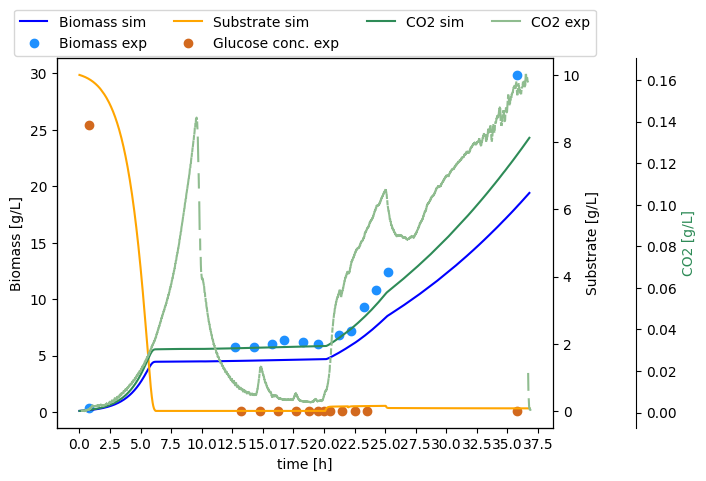

In [7]:
time_pred, biomass_pred, substrate_pred, co2_pred = model_no2_est(p28_1)
plot_show_no2(time_pred, biomass_pred, substrate_pred, co2_pred)

##### Batch No. 2 - Parameter estimation for Phase 1 and Phase 2

In [2]:
# starting with range of 75% to 125% of the found value from last estimation
Yxs_lb = 0.46*0.75; Yxs_ub = 0.46*1.85
Yco2s_lb = 0.003*0.75; Yco2_ub = 0.003*1.25
qs_max_lb = 1.6*0.75; qs_max_ub = 1.6*1.25 # old value: 1.125
Ks_lb = 0.68*0.75; Ks_ub = 0.68*1.25
m_s_lb = 0.04*0.75; m_s_ub = 0.04*1.25
lag_lb = 0.1913*0.75; lag_ub = 0.1913*1.25

In [3]:
# Set the number of samples and parameters
num_samples = 50
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [Yxs_lb, Yxs_ub],       # Range for parameter 0 - Yxs
    [Yco2s_lb, Yco2_ub],    # Range for parameter 1 - Yco2s
    [qs_max_lb, qs_max_ub], # Range for parameter 2 - qs_max
    [Ks_lb, Ks_ub],         # Range for parameter 3 - Ks
    [m_s_lb, m_s_ub],       # Range for parameter 4 - m_s
    [lag_lb, lag_ub],       # Range for parameter 5 - lag
]

LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)

print(LHS_samples.shape)
parameter_bounds

(50, 6)


[[0.34500000000000003, 0.8510000000000001],
 [0.0022500000000000003, 0.00375],
 [1.2000000000000002, 2.0],
 [0.51, 0.8500000000000001],
 [0.03, 0.05],
 [0.0, 0.0]]

**Part 1: Batch Phase**

In [5]:
df_all_sets = pd.DataFrame(columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])

    # Make the predictions and calculate the error
    rmse, time_pred, biomass_pred, substrate_pred, co2_pred = objective_function_no2_part1(init_p)
    # save the parameters in a dataframe
    append_list=[set_num, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
    rmse_one_set.append(append_list)

    # Make a plot and save it
    title = f'set{set_num}/ rmse: {round(rmse, 3)}'
    plot_name = f'set{set_num}_rmse{int(rmse)}'

    if rmse < float(0.5):
        plot_save_no2_est(time_pred, biomass_pred, substrate_pred, co2_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)

df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/batch_no2/estimation/data9_part1.csv')

df_all_sets.head(10)

,set,Yxs,Yc02s,qs_max,Ks,m_s,lag,rmse
38,38,0.567148,0.002650,1.623095,0.554103,0.039804,0.192209,0.323
28,28,0.571168,0.002341,1.450667,0.644359,0.039502,0.188327,0.328
45,45,0.586183,0.002953,1.771742,0.610898,0.040262,0.171015,0.339
47,47,0.537194,0.003646,1.824992,0.652840,0.037922,0.172955,0.348
6,6,0.591809,0.002497,1.261026,0.769208,0.036929,0.150591,0.349
44,44,0.554746,0.003358,1.276025,0.687328,0.034399,0.226874,0.356
33,33,0.602287,0.002585,1.483478,0.734822,0.031181,0.217631,0.371
36,36,0.542125,0.002549,1.580181,0.623070,0.040635,0.232994,0.372
26,26,0.612833,0.002461,1.390332,0.603386,0.033545,0.197532,0.401
25,25,0.621238,0.002250,1.684696,0.768334,0.042624,0.200404,0.406


In [9]:
# chosen based on the co2 peak
p_5 = [0.567885, 0.003185, 1.241015, 0.566899, 0.035483, 0.185016]
p_29 = [0.533737, 0.003005, 1.305099, 0.819724, 0.036199, 0.156050]
p_44 = [0.554746, 0.003358, 1.276025, 0.687328, 0.034399, 0.226874]

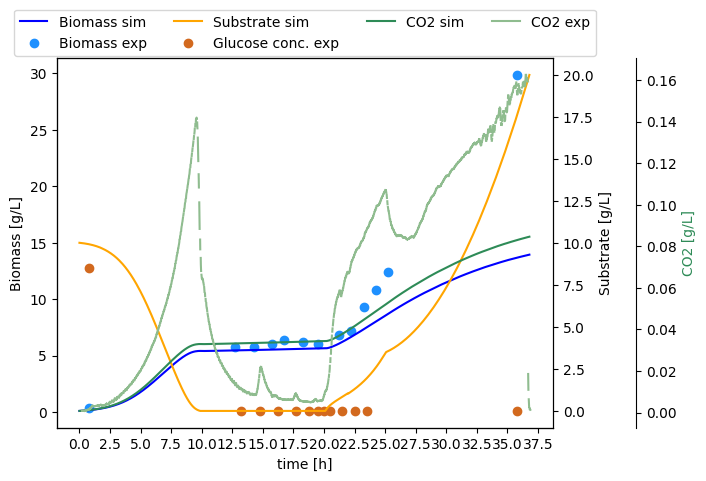

In [10]:
time_pred, biomass_pred, substrate_pred, co2_pred = model_no2_est(p_44)
plot_show_no2(time_pred, biomass_pred, substrate_pred, co2_pred)

**Part 2: Fed-Batch Phase**

In [6]:
# starting with range of 75% to 125% of the found value from last estimation
Yxs_lb = 0.85*0.85; Yxs_ub = 0.85*1.25
Yco2s_lb = 0.005*0.75; Yco2_ub = 0.005*1.25
qs_max_lb = 1.9*0.85; qs_max_ub = 1.9*1.25 # old value: 1.125
Ks_lb = 0.68*0.75; Ks_ub = 0.68*1.25
m_s_lb = 0.04*0.75; m_s_ub = 0.04*1.25
lag_lb = 0.0; lag_ub = 0.0

In [7]:
# Set the number of samples and parameters
num_samples = 50
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [Yxs_lb, Yxs_ub],       # Range for parameter 0 - Yxs
    [Yco2s_lb, Yco2_ub],    # Range for parameter 1 - Yco2s
    [qs_max_lb, qs_max_ub], # Range for parameter 2 - qs_max
    [Ks_lb, Ks_ub],         # Range for parameter 3 - Ks
    [m_s_lb, m_s_ub],       # Range for parameter 4 - m_s
    [lag_lb, lag_ub],       # Range for parameter 5 - lag
]

LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)

print(LHS_samples.shape)
parameter_bounds

(50, 6)


[[0.7224999999999999, 1.0625],
 [0.00375, 0.00625],
 [1.615, 2.375],
 [0.51, 0.8500000000000001],
 [0.03, 0.05],
 [0.0, 0.0]]

In [ ]:
df_all_sets = pd.DataFrame(columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])

    # Make the predictions and calculate the error
    rmse, time_pred, biomass_pred, substrate_pred, co2_pred = objective_function_no2_part2(init_p)
    # save the parameters in a dataframe
    append_list=[set_num, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
    rmse_one_set.append(append_list)

    # Make a plot and save it
    title = f'set{set_num}/ rmse: {round(rmse, 3)}'
    plot_name = f'set{set_num}_rmse{int(rmse)}'

    if rmse < float(3.5):
        plot_save_no2_est(time_pred, biomass_pred, substrate_pred, co2_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'Yxs', 'Yc02s', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)

df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/batch_no2/estimation/data10_part2.csv')

df_all_sets.head(10)